<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/mercari_Keras_functional_model_with_multiple_inputs_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 04th March, 2023
# Myfolder: /home/ashok/Documents/mercari_price_challenge
# Ref: https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl
# VM: lubuntu_deeplearning_II
#
#     Objectives:
#                1. Learning functional model of keras
#                2. Functional model with multiple inputs
#                3. Applying deeplearning to structured tables
#                4. Vector conversion of categorical variables
#                   as also descriptive text


## [Problem](https://www.kaggle.com/c/mercari-price-suggestion-challenge/overview)

It can be hard to know how much something’s really worth. Small details can mean big differences in pricing. For example, one of these sweaters cost $335 and the other cost $9.99. Can you guess which one’s which?

Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.

Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

In this competition, Mercari’s challenging you to build an algorithm that automatically suggests the right product prices. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.

Note that, because of the public nature of this data, this competition is a “Kernels Only” competition. In the second stage of the challenge, files will only be available through Kernels and you will not be able to modify your approach in response to new data. Read more details in the data tab and Kernels FAQ page. 


## Call libraries

In [5]:
# 1.0 Call libraries
# 1.1 Data manipulation libraries
import numpy as np
import pandas as pd

# 1.2 sklearn libraries
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# 1.3 For plotting NN model
#  conda install -c anaconda graphviz
#  conda install -c anaconda pydot
#from skimage import io
#import pydot

# 1.4 Keras model components
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# 1.4.1 For text (word) to integer transformation
from tensorflow.keras.preprocessing.text import Tokenizer

# 1.4.2 For making all integer sequences of equal length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1.4.3 Import backend to invoke tensorflow commands to manipulate tensors
from tensorflow.keras import backend as K

# 1.5 Plotting libraries
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline 

# 1.6 Misc
import math, time, os,gc

In [29]:
# 1.7 Check tensorflow version:

tf.__version__    # 2.9.2

'2.11.0'

In [30]:
# 1.8 Print all outputs from a cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## RMSLE 
Root mean squared Logaritmic error is defined, as below. Here, $p_{i}$ is predicted value AND not probability.  See [here](https://hrngok.github.io/posts/metrics/#Root-Mean-Squared-Logaritmic-Error-(RMSLE)) and also [this article](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a).

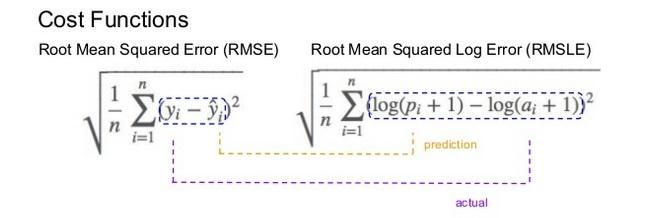

Mechanism:  
It is the Root Mean Squared Error of the log-transformed predicted and log-transformed actual values. RMSLE adds 1 to both actual and predicted values before taking the natural logarithm to avoid taking the natural log of possible 0 (zero) values. As a result, the function can be used if actual or predicted have zero-valued elements. But this function is not appropriate if either is negative valued.


Functionality:
The expression: `log(pi+1)−log(ai+1)`
can be written as `log((pi+1)/(ai+1))` <br>
RMSLE measures the log of ratio of predicted and actual target values. 
(Note: )

#### RMSLE is preferable when
> Targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc <br>
> We care about percentage errors rather than the absolute value of errors. <br>
> There is a wide range in the target variables and we don’t want to penalize big differences when both the predicted and the actual are big numbers. <br>
> We want to penalize under estimates more than over estimates. That is donot sell at lower cost. But overestimate is OK.

For example for P = 1000 and A = 500 would give you the roughly same error as when P = 100000 and A = 50000.



See [here](https://datascience.stackexchange.com/a/69744)
RMSLE has the meaning of a relative error, while RMSE is an absolute error. Choosing one depends on the nature of your problem. Imagine that the target spans values from around 1 to around 100. Is predicting y^=1.01 for true y=1 as bad as y^=101 for y=100? Then RMSLE might be a good choice. With RMSE, on the other hand, predicting y^=2 for y=1 is as bad as y^=101 for y=100.

In [ ]:
# 1.8 Underestimate by 400
#     More penalized:

p = 600
a = 1000
(math.log(p) - math.log(a))**2


0.2609428178959133

In [ ]:
# 1.9 Overestimate by 400

p =  1400
a = 1000
(math.log(p) - math.log(a))**2


0.11321356601688151

### Define rmsle()

In [37]:
# 2. Write a function to calculate Root Mean Squared Logarithmic Error (RMSLE)
#    'y' and 'y_pred' are arrays of actual vs predicted values.
#    Why use RMSLE?
#    Ref: https://stats.stackexchange.com/a/110610

def rmsle(y, y_pred):
    # 2.1 Check if lengths are both arrays are same
    assert len(y) == len(y_pred) 
    # 2.2 Get a list of squared differences of logs
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    # 2.3 Sum up all squared differences, take a mean and then square root 
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
    
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

In [32]:
# 2. Write a function to calculate Root Mean Squared Logarithmic Error (RMSLE)
#    'y' and 'y_pred' are arrays of actual vs predicted values.
#    Why use RMSLE?
#    Ref: https://stats.stackexchange.com/a/110610

def rmsle(y, y_pred):
    # 2.1 Check if lengths are both arrays are same
    assert len(y) == len(y_pred) 
    # 2.2 Get a list of squared differences of logs:
    t = np.sum(
               (
                   np.sqrt(
                            (np.log(y_pred+1) - np.log(y+1))**2
                           )
                )
               ) / len(y)
    return t
  

## Mount gdrive
And also set path to data

In [6]:
# 2.3
from google.colab import drive
drive.mount('/gdrive')  

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [7]:
# 2.4 Set path to train and test data
path = "/gdrive/MyDrive/Colab_data_files/mercari/"

## Read data
Read both train/test data.<br>
Just plain reading

In [8]:
# 3.0 Read datasets

print("---Loading data---")

train = pd.read_table(path+"train.tsv.zip")

# 3.0.1
test = pd.read_table(path+"test.tsv.zip")

print("---finished reading---")

---Loading data---
---finished reading---


In [ ]:
# 3.1
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [38]:
# 3.2 Print some information about datasets
#     In this data target is 'price':

print("---")
print(f"train shape: {train.shape}")   # (1482535, 8)
print(f"Test shape: {test.shape}")     #  (693359, 7)
print("---\n")

# 3.2.1
print(f"train Memory Usage : {sum(train.memory_usage())/10**6} MB")   # In MB
print(f"test Memory Usage : {sum(test.memory_usage())/10**6} MB")    # In MB
print("-----\n")

# 3.2.2 Missing values
print(f"Train Null columns: {train.isnull().sum().sort_values()}")
print(f"Test Null columns: {test.isnull().sum().sort_values()}" )

---
train shape: (1482535, 8)
Test shape: (693359, 7)
---

train Memory Usage : 94.882368 MB
test Memory Usage : 38.828232 MB
-----

Train Null columns: train_id                  0
name                      0
item_condition_id         0
price                     0
shipping                  0
item_description          4
category_name          6327
brand_name           632682
dtype: int64
Test Null columns: test_id                   0
name                      0
item_condition_id         0
shipping                  0
item_description          0
category_name          3058
brand_name           295525
dtype: int64


In [39]:
# 3.3 All columns but 'price' and shipping are categorical
train.dtypes

train.columns.values

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

array(['train_id', 'name', 'item_condition_id', 'category_name',
       'brand_name', 'price', 'shipping', 'item_description'],
      dtype=object)

## Data pre-processing
>1. Missing values (three columns)<br>
>2. Label Encoding of categorical columns (three)<br>
>3. Transform fields having descriptive text to int sequences (two)<br>
>4. In each text field, find the length of int sequence with max  length<br>
>5. Scale numeric fields (two)<br>
>6. Create one random numeric field<br>

## Missing values
Fill missing values in categorical columns with `'missing'` 


In [9]:
# 4.0 Fill missing values
#     Define a function to fill missing values
#     We use pandas methods df.fillna()
#     Fields: category_name, brand_name, item_description

def fill_missing(dataset):
    dataset["category_name"].fillna(value="missing", inplace=True)
    dataset["brand_name"].fillna(value="missing", inplace=True)
    dataset["item_description"].fillna(value="No description yet", inplace=True)
    return (dataset)

In [10]:
# 4.1 Fill all missing values now in train and test:

train = fill_missing(train)
test = fill_missing(test)

In [11]:
# 4.2 Check if any value is still missing:

train.isnull().sum()
test.isnull().sum()

# 4.3 Look at datasets now
train.head(3)
test.head(3)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,missing,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,missing,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...


## Label Encoding of `category_name `
Label encode `category_name` and `brand_name` fields.<br> We will first horizontally merge `category_name` values and `brand_name` values both in train and test.<br>
We note <font color = "Red"> `MAX_CATEGORY_VOC` </font>
  


In [13]:
# 5.0 Label Encode categorical values
#     Two columns: category_name and brand_name

# 5.1 Look at train/test category_name data. Each is 1D array:
train["category_name"].values.shape        # 1D (1482535,)
test.category_name.values.shape         # 1D (693359,)

(693359,)

In [14]:
# 5.2 Merge 1D category_name data of train & test into one array.
#     This array will be later deleted:

catname_array = np.hstack([np.unique(train.category_name.values), np.unique(test.category_name.values)])

In [15]:
# 5.3 So final shapes:
catname_array.shape        # 1D array, (2175894,) ; 2512


# 5.4 And some values
catname_array[:3]


array(['Beauty/Bath & Body/Bath',
       'Beauty/Bath & Body/Bathing Accessories',
       'Beauty/Bath & Body/Cleansers'], dtype=object)

In [16]:
le.classes_

array(['Beauty/Bath & Body/Bath',
       'Beauty/Bath & Body/Bathing Accessories',
       'Beauty/Bath & Body/Cleansers', ...,
       "Women/Women's Handbags/Shoulder Bag",
       "Women/Women's Handbags/Totes & Shoppers", 'missing'], dtype=object)

In [17]:
le.transform(le.classes_)

array([   0,    1,    2, ..., 1285, 1286, 1287])

In [18]:
# 5.5 Label or integer encode each category

# 5.6 Instantiate object for category name transformation:

le = LabelEncoder()

# 5.7 Training first on 'catname_array' :

le.fit(catname_array)

LabelEncoder()

In [19]:
# 5.8 Next transformation of individual sets:

train.category_name = le.transform(train.category_name.values)
test.category_name = le.transform(test.category_name.values)

In [20]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,503,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,1204,missing,44.0,0,Complete with certificate of authenticity


In [21]:
# 5.9 How many classes:
le.classes_

array(['Beauty/Bath & Body/Bath',
       'Beauty/Bath & Body/Bathing Accessories',
       'Beauty/Bath & Body/Cleansers', ...,
       "Women/Women's Handbags/Shoulder Bag",
       "Women/Women's Handbags/Totes & Shoppers", 'missing'], dtype=object)

In [22]:
# 5.10 Length:

MAX_CATEGORY_VOC = len(le.classes_)
print("\n======\n")
f"Mac vocabulary size for category: {MAX_CATEGORY_VOC}"

'Mac vocabulary size for category: 1311'

In [23]:
# 5.11 Delete 'catname_array':

print(np.max(catname_array))
del catname_array

missing


## Label Encoding `brand_name`
We note <font color = "Red">`MAX_BRAND_VOC`</font>


In [24]:
# 6.0 Also merge brand_name data into one dimensional array

brname_array = np.hstack([np.unique(train.brand_name.values), np.unique(test.brand_name.values)])
brname_array.shape         # 1D array, (2175894,)
brname_array[:3]

array(['!iT Jeans', '% Pure', '10.Deep'], dtype=object)

In [25]:
# 6.1 Instantiate another object for 'brand name' transformation:

le = LabelEncoder()

# 6.2 fit and transform:

le.fit(brname_array)


LabelEncoder()

In [26]:
# 6.3
train.brand_name = le.transform(train.brand_name.values)
test.brand_name = le.transform(test.brand_name.values)

# 6.4
MAX_BRAND_VOC = len(le.classes_)  # 5290
MAX_BRAND_VOC

5290

In [27]:
# 6.5 How label encoder works:
#     Transforms alphabetically not by frequency
#     Coding starts from 0:

a = ['zx', 'zx', 'az', 'bb', 'bb', 'bb']
le1 = LabelEncoder()
print(le1.fit_transform(a))

# 6.6:

b = ['zx', 'zx','zx','zx', 'az', 'bb', 'bb', 'bb']
le2 = LabelEncoder()
print(le2.fit_transform(b))


[2 2 0 1 1 1]
[2 2 2 2 0 1 1 1]


In [28]:
# 6.7 Delte brname_array:
print(np.max(brname_array))
del le,  brname_array
gc.collect()

wallis


143

## Data after above transformations

In [29]:
# 6.8 Finally look at transformed data:

train.head(3)
test.head(3)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,1205,5265,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,899,5265,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,1000,1094,1,Brand new coach bag. Bought for [rm] at a Coac...


## Transform two text fields to integer sequences
Fields are `item_description` and `name`. <br>
Takes time<br>
By default, `Tokenizer()` removes all punctuation, turning the texts into space-separated sequences of words (words may include the ' character). These sequences are then split into lists of tokens. They are then indexed.<br>
We also note vocabulary size: <font color="Red"> `MAX_TEXT_VOC ` </font>


In [30]:
# 7. Vectorize into integers text data
#    Two columns: item_description, name

# 7.1 We assume that words in 'item_description' and 'name'
#     columns are same or iterchangeable. This assumption
#     is made for simplification. Thst is, T-shirt, if
#     coded as 57 in item_decription' will also be coded 
#     as 57 in 'name' field.
#     (Correct approach may have been to treat the two fields separately. This needs more examination.)

# 7.2 Stack two columns, item_Description and name, as arrays, end-to-end in 1D array
#     We could also have stacked here: test.item_description.values, test.name.values

raw_text = np.hstack(
                     [
                       train.item_description.values,
                       train.name.values,
                       test.item_description.values,
                       test.name.values
                      ]
                     )

# 7.2.1
raw_text[:3]

array(['No description yet',
       'This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.',
       'Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!'],
      dtype=object)

In [31]:
# 7.3 fit on raw_text tokenizer
#     https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
#     Tokenizer filters out punctuation, tabs and line-breaks
#

tok_raw = Tokenizer()           # Create Tokenizer() object
tok_raw.fit_on_texts(raw_text)  # Just training. No transformation as yet


In [32]:
# 7.4 Look at top 10 word indicies
#     Integer mapping is by freq of occurrence
#     unlike in label endocder:

tok_raw.word_index

{'and': 1,
 'the': 2,
 'for': 3,
 'a': 4,
 'new': 5,
 'size': 6,
 'in': 7,
 'to': 8,
 'with': 9,
 'is': 10,
 'of': 11,
 'no': 12,
 'free': 13,
 'on': 14,
 'i': 15,
 'brand': 16,
 'condition': 17,
 'you': 18,
 'it': 19,
 'shipping': 20,
 'rm': 21,
 '2': 22,
 'or': 23,
 'black': 24,
 'pink': 25,
 'are': 26,
 'bundle': 27,
 '1': 28,
 'this': 29,
 'worn': 30,
 'used': 31,
 '3': 32,
 'my': 33,
 '5': 34,
 'all': 35,
 'will': 36,
 'never': 37,
 'great': 38,
 'but': 39,
 'not': 40,
 'price': 41,
 'have': 42,
 'from': 43,
 'small': 44,
 '6': 45,
 'one': 46,
 '4': 47,
 'color': 48,
 'your': 49,
 'only': 50,
 'like': 51,
 'be': 52,
 'please': 53,
 'me': 54,
 'as': 55,
 'has': 56,
 'box': 57,
 'good': 58,
 'white': 59,
 'top': 60,
 'tags': 61,
 'can': 62,
 'out': 63,
 '7': 64,
 'if': 65,
 'blue': 66,
 'very': 67,
 'description': 68,
 'medium': 69,
 'lularoe': 70,
 'up': 71,
 'set': 72,
 'large': 73,
 'firm': 74,
 'iphone': 75,
 'so': 76,
 'ship': 77,
 'that': 78,
 'yet': 79,
 '8': 80,
 'secret': 8

In [33]:
# 7.5 And vocab size:

MAX_TEXT_VOC = len(tok_raw.word_index)
MAX_TEXT_VOC   # 321999, say: 322000

321999

In [34]:
# 8. Transform 'item_description' to integer sequences
#    Our trained object tok_raw uses texts_to_sequences()
#    for the purpose. Takes time...

# 8.1 train first
train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.values)

# 8.2 test next

test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.values)


In [35]:
# 8.3 Check transformed data:

train.head(2)
test.head(2)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,seq_item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,1205,5265,1,Size 7,"[6, 64]"
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,899,5265,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...","[439, 802, 5, 64, 34, 9040, 5191, 616, 1024, 7..."


In [36]:
# 9.0 Similarly transform feature 'name' 
#       to integer sequences

# 9.1 train first:
train["seq_name"] = tok_raw.texts_to_sequences(train.name.values)

# 9.2 test, next:
test["seq_name"] = tok_raw.texts_to_sequences(test.name.values)


In [37]:
# 9.3 Look at data again:

train.head(2)
test.head(2)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,seq_item_description,seq_name
0,0,"Breast cancer ""I fight like a girl"" ring",1,1205,5265,1,Size 7,"[6, 64]","[1790, 3476, 15, 5552, 51, 4, 266, 263]"
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,899,5265,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...","[439, 802, 5, 64, 34, 9040, 5191, 616, 1024, 7...","[439, 802, 5, 64, 34, 9040, 5191, 616, 1024]"


## Max vocabulary size of `condition` column
We also note <font color = "Red">`MAX_CONDITION_VOC`</font>

In [38]:
# 9.4 Column, item_condition, already in integer format
MAX_CONDITION_VOC = np.max([
                            train.item_condition_id.max(),
                            test.item_condition_id.max()
                           ]
                          ) + 1

print(f"Maximum Vocabulary size in item_condition_id is {MAX_CONDITION_VOC} ")

Maximum Vocabulary size in item_condition_id is 6 


## Max Vocab Sizes of all cat columns
<font color = "Red">
1. MAX_TEXT_VOC <br>
2. MAX_CATEGORY_VOC<br>
3. MAX_BRAND_VOC<br>
4. MAX_CONDITION_VOC<br></font>

In [39]:
# 9.5
print("1.", MAX_TEXT_VOC )     # 321999
print("2.", MAX_CATEGORY_VOC)  # 1311
print("3.", MAX_BRAND_VOC)     # 5290
print("4.", MAX_CONDITION_VOC) # 6

1. 321999
2. 1311
3. 5290
4. 6


## Histogram to look at distributions
Look at distribution of lengths of integer sequences ie `seq_name` and `seq_item_description`

<AxesSubplot:>

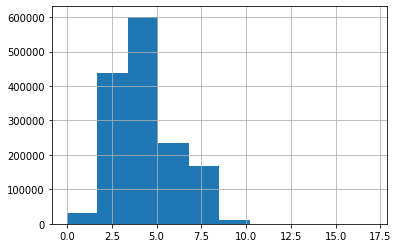

In [40]:
# 10.0 Get histogram of distribution of seq_name lengths
#      Histogram can be used to decide where to cut-off max lengths

train.seq_name.apply(lambda x: len(x)).hist()

<AxesSubplot:>

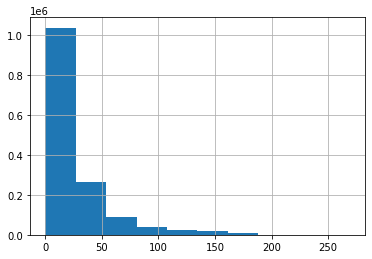

In [41]:
# 10.1 Get histogram of distribution of seq_item_description 
#      Histogram can be used to decide where to cut-off max lengths

train.seq_item_description.apply(lambda x: len(x)).hist()

In [42]:
# 10 EMBEDDINGS: MAX LENGTH OF SEQUENCES
# 10.2 Based on the histograms, we select the max lengths
#      OR timesteps in RNN for two integer sequences, as:
#      Implication: Longer integer sequences will be truncated

MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75

## Target transformation
Scale (take a log of) numeric field and also create a new random numeric field

### Log of 'price' field
>Take a log of 'price' to make it symmetrical  
>Scale the logged values using minmax scaler  
>Scaled price field is called 'target'

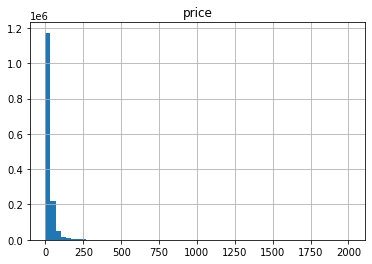

In [43]:
# 11. Histogram of target column:
pd.DataFrame(train.price).hist(bins = 60) ;

In [45]:
#   Transform target variable, 'price': 
#     First take log and then scale log

# 11.1 First take a log of target. Why?
#      Make target values symmetric:

train["target"] = np.log( train.price + 1)   # Add 1 to escape from -ve infinity


In [46]:
# 11.2 Then scale log values using min-max scaler between -1 and 1
#      Why?
#      Scaling between (-1,1) is helpful in NN modeling

target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.values.reshape(-1,1))


In [ ]:
# 11.3 Display histogram of transformed target
#      It is quite symmetric

pd.DataFrame(train.target).hist() ;

## Create one random numeric column
This column will have random number values. The only numeric feature that we have is `'shipping'`. We will create one more  numerical column with random values for better demonstration of our proposed architecture. Otherwise, this column is NOT at all needed.


In [47]:
# 12.0 Create an arbitrary column. Why?
#      We want two numerical columns for better demonstration of our
#      proposed architecture. Otherwise, this column is NOT at all needed

# 12.1 Add some small random values to shipping column and create a new column

train['ship_rand'] = train.shipping + np.random.random(size = train.shipping[0])
train.head(3)

# 12.2
test['ship_rand'] = test.shipping + np.random.random(size = test.shipping[0])
#test.head(3)

# 12.3
train.shape    # (1482535, 12)
test.shape     # (693359, 10)   Missing 'price' and its transformed column 'target'


(693359, 10)

## Modeling--initial steps
>Split data<br>
>Expt with pad_sequences()<br>
>Define a function to create a dictionary of data

## Split data

In [48]:
# 13. Split into train and test
#     Note that we do not have 'y' here. 
#     Why? Because 'price' is a continuous variable

# 13.1 Just 'train' will be split into two parts
#      This is permissible in sklearn syntax

dtrain, dvalid = train_test_split(train,
                                  random_state=123,
                                  train_size=0.99    # 99% vs 1%
                                 )

# 13.2
print(dtrain.shape)     # (1467709, 12)
print(dvalid.shape)     # (14826, 12) 1% of above

(1467709, 12)
(14826, 12)


## Experiment with pad_sequences
Our dataset has:<br>
> 1. Categorical columns
>> Three integer columns: <b>item_condition_id</b>, <b>category_name</b> and <b>brand_name</b><br>
>> Two columns (of integer sequences): <b>seq_item_description</b> and <b>seq_name</b><br>

> 2. Numeric columns (two): <b>shipping, ship_rand</b><br>
> 3. Target column 'target'<br>

Thus total number of columns are: 3 +2 + 2+ 1 = 8


In [ ]:
# 14.1 Just have a look at the train data:
dtrain.head(3)

Integer sequence columns `seq_item_description` and `seq_name` must have sequences of equal length. So we pad-sequences in each column. Here is what padding does.

In [116]:
# 14.2 Using keras pad_sequences function:
#      Example

print(f" Max size of sequence: {MAX_NAME_SEQ}")
print(f" Shape of dtrain.seq_name: {dtrain.seq_name.shape}")

# 14.3
s = pad_sequences(
                   dtrain.seq_name,
                   maxlen=MAX_NAME_SEQ
                  )

 Max size of sequence: 10
 Shape of dtrain.seq_name: (1467709,)


In [ ]:
# 14.4 As 's' will be a numpy array
#       to observe it let us transform it
#        into pandas dataframe:

print(f"Shape of s: {s.shape}")

# 14.5 Here is dataframe:
pd.DataFrame(s).head(3)

## Define a function and also create a dictionary of data
That is we are sort of transforming pandas dataframe to a dictionary as per our conveience


In [ ]:
# 15.0 Our data
dtrain.head(2)

In [208]:
# 15.1 As we want to process, different cols differently,
#      for these columns, we need as many datasets. 
#      WE have SIX columns or column-sets for processing.

#      Define a function that creates datasets in 
#      a dictionary format to help to feed data into keras
#      All columns but the last 'num_vars' are categorical
#      So all columns but the last begin with Embedding layer

def get_keras_data(dataset):
    X = {   
        'name_in':           pad_sequences(dataset.seq_name,
                                           maxlen=MAX_NAME_SEQ       # 10
                                           ),                                                            # 1
        'item_desc_in':      pad_sequences(
                                           dataset.seq_item_description,
                                           maxlen=MAX_ITEM_DESC_SEQ  # 50
                                           ),                                                             # 2
        'brand_name_in':     np.array(dataset.brand_name),                                                # 3
        'category_name_in':  dataset.category_name.values,                                                # 4
        'item_condition_in': dataset.item_condition_id.values,                                            # 5
        'num_vars_in':       np.array(dataset[["shipping", "ship_rand"]])    # Two numeric columns here   # 6
    }
    return X


In [60]:
X_train = [name_in, item_desc_in, brand_name_in, category_name_in, item_condition_in,num_vars_in]

In [49]:
name_in =    pad_sequences(dtrain.seq_name,
                                           maxlen=MAX_NAME_SEQ       # 10
                                           )                                                           # 1


In [50]:
item_desc_in=      pad_sequences(
                                           dtrain.seq_item_description,
                                           maxlen=MAX_ITEM_DESC_SEQ  # 50
                                           )

In [51]:
brand_name_in =  np.array(dtrain.brand_name),

In [52]:
category_name_in =  dtrain.category_name.values 

In [55]:
item_condition_in =dtrain.item_condition_id.values                                            # 5

In [57]:
num_vars_in=    np.array(dtrain[["shipping", "ship_rand"]]) 

In [209]:
# 15.2 Get these datasets now:

X_train = get_keras_data(dtrain)  # type: dict

In [135]:
# 15.3

X_train.keys()

dict_keys(['name_in', 'item_desc_in', 'brand_name_in', 'category_name_in', 'item_condition_in', 'num_vars_in'])

In [ ]:
# 15.4  Observe X_train:
#        Just print two objects
#        for each data:

for key, value in X_train.items():
    print("\n\n============")
    print(key, ' : ', value[:2])

In [129]:
# 16.0 Similarly get subsets 
#        for X_valid and X_test:

X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [ ]:
# 16.1 As each dict item is a numpy array,
#      we can check shapes. We need these below:

print(X_train["name_in"][:4])
print("\n===========")
print(X_train["name_in"].shape)

In [ ]:
# 16.2 Check more shapes.

print(X_train["item_desc_in"][:4])
print("\n\n===========")
print(X_train["item_desc_in"].shape)

In [ ]:
# 16.3 Check more shapes. 

X_train["num_vars_in"][:4]
print("\n ----")
X_train["num_vars_in"].shape[1]       # 2

array([[1.       , 1.3366546],
       [1.       , 1.3366546],
       [0.       , 0.3366546],
       [1.       , 1.3366546]])


 ----


2

## About embedding of categorical values in vector-space
Small write up


### A
Consider following sentences:<br><p>
1. mango is sweet<br>
2. apple is sweet<br>
3. mouse moves pointer<br>
4. iphone mobile is used for communication<br>

In a dataset there are multiple text/nominal columns. The nominal values in any column are related with one another. Consider the following table with three categorical columns. For example, mango, apple, grapes and banana in column 'x1' are related to one another through the target, 'x3'. Similarly, items disk, laptop, mouse and mobile in column 'x2' are related to one another through 'x3'.  

We, therefore, need two distinct embedding layers in this dataset.   

An embedding layer will converts word to vector-spaces to discover relationship among words. Or, one can say that conversion of a word to vectors, facilitates finding association between context words. See picture below.


| x1   |   x2    |   x3    |
|------|---------|---------|  
|mango |  disk   |  23  |
|apple |  laptop   |  36  |
|grapes | mouse |  80  |
|banana| mobile  |25|

Conversion of categorical values to word-vectors also helps discover better association between mango and 23 OR apple and 64 than by simply label encoding them and applying machine learning algo to discover patterns.

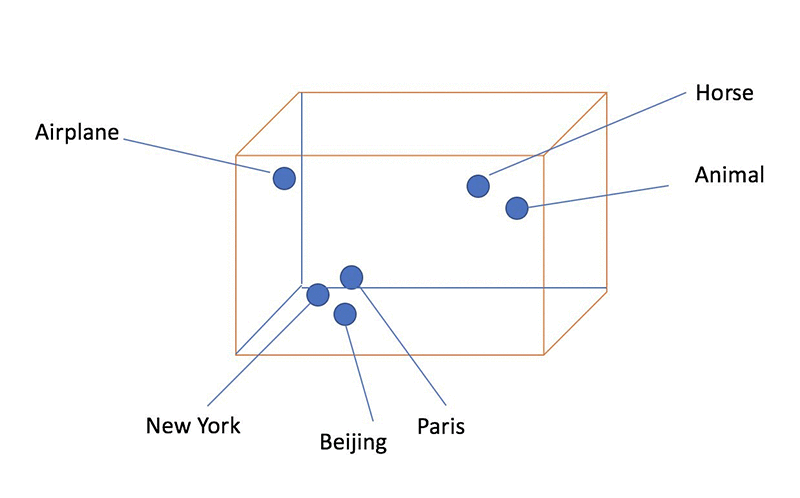

## Model

### Callback functions
Ignore these in first reading

#### Why Early stopping works?
Explore modeling surfaces [here](https://losslandscape.com/explorer). Study optimization techniques [here](https://www.kdnuggets.com/2020/12/optimization-algorithms-neural-networks.html)

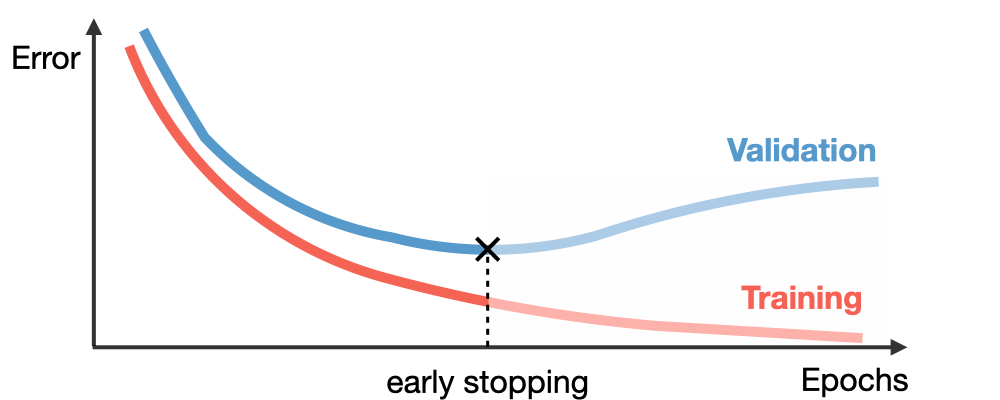

In [ ]:
# 17.0 Define callback function for earlystopping and storing weights
#      May forget this in the first reading:

# 17.0.1 Place where checkpoint data will be stored
checkptfilepath = "/content/model"

# 17.0.2 Delete if it exists

! rm -r -f /content/model



In [ ]:
# 17.0.3 Define callbacks now:

callbacks = [
    EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    ),

    ModelCheckpoint( filepath=checkptfilepath, save_best_only=True)
]


In [ ]:
# 18.1 Forget it in first reading. Another loss function
#      Any functions used in the model must use tensors
#      and not numpy arrays. Of course, dataset can be numpy:

def rmsle_cust(y_true, y_pred):
    first_log = K.log(
                       K.clip(y_pred,
                              K.epsilon(),
                              None
                              ) + 1.
                      )
    
    second_log = K.log(
                        K.clip(y_true,
                               K.epsilon(),    # Min value
                               None            # max value  
                               ) + 1.
                       )
    out = K.sqrt(
                  K.mean(
                          K.square(
                                    first_log - second_log
                                   ),
                          axis=-1)    # -1 means the last axis
                  )

    return out

### Constants
Sizes of word2vec for
> a) two text columns, <br>
> b) for brand_name and category_name **cols**<br>
> c) for item_condition col<br>

In [58]:
# 19.0 Define sizes of categorical values AND word to vectors
#      Sizes?

word2vec_size = 50   # For text columns: seq_name and seq_item_description
cat2vec_size = 10    # For brand_name and category_name 
cond2vec_size = 5    # For item_condition col

### Input tensors
Recall that purpose of Input layer is to output a tensor of appropriate shape for the subsequent layers. Thus `Input()` requires input data-shape and a name (if there are more than one Input).

About Input shapes:<br>
**Input layer: Dense**<br>
Input will be one row at a time. So shape is number of features<br>
**Input layer: Conv2D:**<br>
Input will be Image at a time. So Shape is size of image: width * height * depth. depth is also called 'channels'. <br>
**Input layer: Conv1D:**<br>
Input will be one row at a time. So shape will be: No of features * depth<br>
**Input layer: Embedding layer**<br>
Inputs will be: a) Length of each sequence and, b) Size of vector to which each integer in the sequence is to be transformed to ie word2vec size.<br>  

### Embedding layers and RNN
Diagrammetic Explanations 

Let us see visually an overall picture of how modeling takes place. 

#### For 'brand' and 'category'

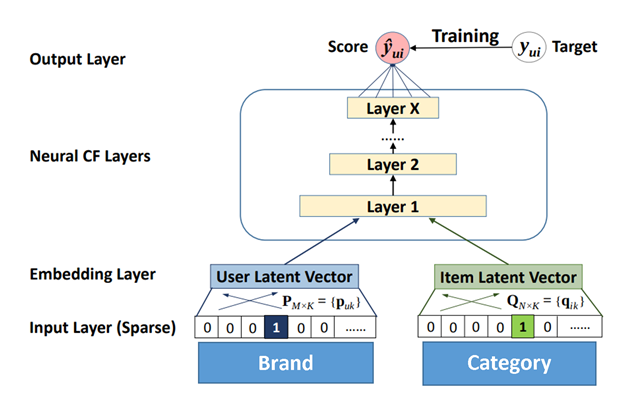

✅   After repeated iterations over data, Word2vec for every *Brand* and every *Category* will finally stabilise at values that minimizes the MSE in price-prediction. Having Word2Vec as inputs to Classification layers is a better alternative than merely OneHotEncode as inputs that are fixed and unchanging. 

#### For 'name' and 'item-description'

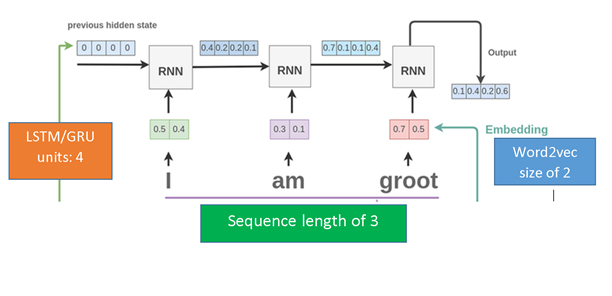

#### More detailed for name and item-description
In each *Embedding layer* specify the <u>vocabulary size</u> and <u>word2vec</u> size. In the following diagram, we assume that our maximum comment/phrase size is 2 ('go home').  And, we are also transforming each word (eg, 'GO') to a vector of size two (0.35, 0.90).  
Phrase size will decide the number of RNNs or LSTMs or GRUs we will have.

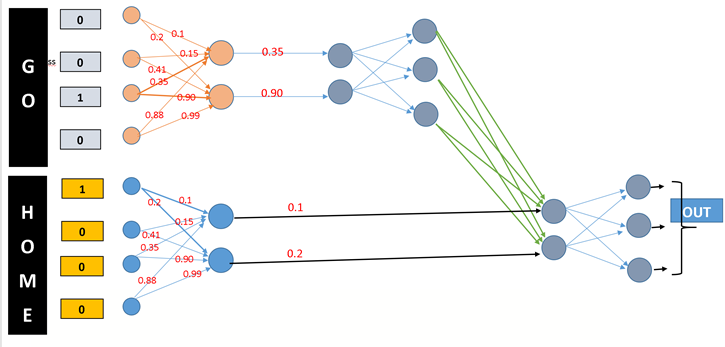

#### LSTM/GRU

While an LSTM or GRU have two outputs, the number of bits or 'units' for both *ct* (ie *state*) and *ht* (ie *output*) are same. Thus, in the syntax for LSTM or GRU only units parameter has to be specified. See [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) syntax of lstm and [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) syntax of GRU.

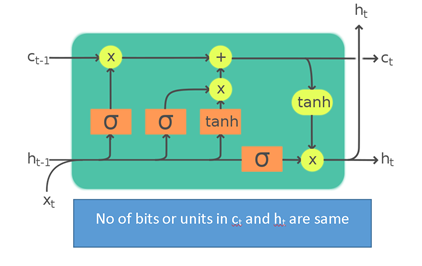

The Gated Recurrent Unit (GRU) is a type of Recurrent Neural Network (RNN) that, in certain cases, has advantages over long short term memory (LSTM). GRU uses less memory and is faster than LSTM, however, LSTM is more accurate when using datasets with longer sequences.

### Input layers definititon

What all numbers do we need, at the minimum?  
Before we proceed further, there should be clarity about these. At the minimum three numbers have to be specified. Seq length, word2vec size and number of output units of RNN/LSTM/GRU.

In [67]:
X_train = [name_in, item_desc_in, brand_name_in, category_name_in, item_condition_in,num_vars_in]

In [68]:
# 20.1 SIX Inputs. At each input specify number of input-features:

name =            Input(shape=(X_train[0].shape[1]),      name="name_in")           # Length of each sequence
item_desc =       Input(shape=(X_train[1].shape[1]), name="item_desc_in")      # Length of each sequence
brand_name =      Input(shape=(1,),                             name="brand_name_in")     # Just 1 feature. Hence shape=[1]
category_name =   Input(shape=(1,),                             name="category_name_in")  # Just 1 feature. Hence shape=[1]
item_condition =  Input(shape=(1,),                             name="item_condition_in") # Just 1 feature. Hence shape = [1]
num_vars =        Input(shape=(X_train[5].shape[1]),  name="num_vars_in")


### Embedding layer

In [ ]:
# 20.2 FIVE Embeddings layers.  Embedding vectors of 2 + 3, for FIVE of the above

In [69]:
# 20.3   Output of following two also go in RNN.
#        RNN output needs no flattening as this output is received
#        AFTER all timesteps have been fed into RNN:

emb_name =           Embedding(MAX_TEXT_VOC,      word2vec_size  )(name)               
emb_item_desc =      Embedding(MAX_TEXT_VOC,      word2vec_size  )(item_desc)


In [70]:
emb_name.shape
emb_item_desc.shape

TensorShape([None, 75, 50])

In [71]:
# 20.3.1 Output of following three go directly into Dense layer after flattening
#        These need to be flattened as for every timestep there is a vector:

emb_brand_name =     Embedding(MAX_BRAND_VOC,     cat2vec_size  )(brand_name)
emb_category_name =  Embedding(MAX_CATEGORY_VOC,  cat2vec_size  )(category_name)
emb_item_condition = Embedding(MAX_CONDITION_VOC, cond2vec_size )(item_condition)

### RNN layers after embedding layer
The above diagram also explains output of RNN (read GRU).

In [ ]:
#word2vec_size = 50   # For text columns: seq_name and seq_item_description
#cat2vec_size = 10    # For brand_name and category_name 
#cond2vec_size = 5 

In [72]:
# 21 TWO RNN layers. Both these are independent of each other:

rnn_layer2 = GRU(8) (emb_name)          # Output of GRU is a vector of size 8
rnn_layer1 = GRU(16) (emb_item_desc)    # Output of GRU is a vector of size 16

In [73]:
rnn_layer2.shape
rnn_layer1.shape

TensorShape([None, 16])

### Conv1D layers


We could have fed each or one of the *Embedding layer* outputs to Conv1D. But we will not do so. Left as an exercise for students. Below commented code gives an hint. You will be able to do this only if the incoming layer is large enough so that convolution operation does not reduce it to negative numbers.

In [ ]:
# 22.0
# rnn_layer1 = Reshape([rnn_layer1.shape[1],1])(rnn_layer1)
# rnn_layer1 = Conv1D( filters = 32,kernel_size = 3,activation = 'relu')(rnn_layer1)

### Concatenation

In [74]:
# 23. Before we concatenate, let us see shape of 
#     each output tensor. We may have to flatten few:

print(f"emb_brand_name: {emb_brand_name.shape}")            # (None, 1, 10)--Flatten it
print(f"emb_category_name: {emb_category_name.shape}")      # (None, 1, 10)--Flatten it
print(f"emb_item_condition: {emb_item_condition.shape}")    # (None, 1, 5)--Flatten it
print(f"rnn_layer1: {rnn_layer1.shape}")                    # (None, 16)
print(f"rnn_layer2: {rnn_layer2.shape}")                    # (None, 8)


emb_brand_name: (None, 1, 10)
emb_category_name: (None, 1, 10)
emb_item_condition: (None, 1, 5)
rnn_layer1: (None, 16)
rnn_layer2: (None, 8)


### One way to avoid flattening before **concatenation**

In [75]:
# Test
tf.keras.layers.concatenate([emb_brand_name, emb_category_name, emb_item_condition])

<KerasTensor: shape=(None, 1, 25) dtype=float32 (created by layer 'concatenate')>

In [76]:
# Reahpe these two:
rnn_layer1 = tf.keras.layers.Reshape(target_shape = (1,16))(rnn_layer1)
rnn_layer2 = tf.keras.layers.Reshape(target_shape = (1,8) )(rnn_layer2)

In [148]:
num_vars.shape

TensorShape([None, 2])

In [77]:
num_vars1= tf.keras.layers.Reshape(target_shape = (1,2))(num_vars)

In [78]:
# Test if successful:
main_1 = tf.keras.layers.concatenate([emb_brand_name, emb_category_name, emb_item_condition, rnn_layer1, rnn_layer2, num_vars1])

In [185]:
main_1.shape

TensorShape([None, 1, 51])

### Else, Flatten() and concatenate

In [ ]:
# 23.1 Concatenate all layer-branches:

main_1 = concatenate(
                        [
                          Flatten() (emb_brand_name),
                          Flatten() (emb_category_name),
                          Flatten() (emb_item_condition),
                          rnn_layer1,       # Flatten()(rnn_layer1),
                          rnn_layer2,
                          num_vars          # Feed numerical variables as they are
                        ]
                      )

### Design Classification layer

In [196]:
main_1.shape

TensorShape([None, 1, 51])

In [79]:
main_1 = Flatten()(main_1)

In [80]:
main_1.shape

TensorShape([None, 51])

In [81]:
# 24.0 Level of dropouts: 10%
dr_r = 0.1   

# 24.1 Add classification layer
main_l = Dense(128) (main_1)
main_l = Dropout(dr_r)(main_1)
main_l = Dense(64) (main_1)
main_l = Dropout(dr_r) (main_1)

In [82]:
# 24.1 Output neuron
output = Dense(1, activation="linear") (main_l)

## Final Model

In [83]:
# 25 Formulate Model now
model = Model(
              inputs= [                     
                        name,
                        item_desc,
                        brand_name,
                        category_name,
                        item_condition,
                        num_vars
                       ],
              outputs= output
              )

### Model as a function
Skip but correct and works

In [ ]:
# 24.3 Put all the above under one function:

def create_model():
    # SIX Inputs
    name =            Input(shape=(X_train["name_in"].shape[1]),      name="name_in")           # Length of each sequence
    item_desc =       Input(shape=(X_train["item_desc_in"].shape[1]), name="item_desc_in")      # Length of each sequence
    brand_name =      Input(shape=(1,),                             name="brand_name_in")     # Just 1 feature. Hence shape=[1]
    category_name =   Input(shape=(1,),                             name="category_name_in")  # Just 1 feature. Hence shape=[1]
    item_condition =  Input(shape=(1,),                             name="item_condition_in") # Just 1 feature. Hence shape = [1]
    num_vars =        Input(shape=(X_train["num_vars_in"].shape[1]),  name="num_vars_in")
    # Embedding layer
    emb_name =           Embedding(MAX_TEXT_VOC,      word2vec_size  )(name)               
    emb_item_desc =      Embedding(MAX_TEXT_VOC,      word2vec_size  )(item_desc)
    emb_brand_name =     Embedding(MAX_BRAND_VOC,     cat2vec_size  )(brand_name)
    emb_category_name =  Embedding(MAX_CATEGORY_VOC,  cat2vec_size  )(category_name)
    emb_item_condition = Embedding(MAX_CONDITION_VOC, cond2vec_size )(item_condition)

    # TWO RNN layers. 
    rnn_layer2 = GRU(8) (emb_name)          
    rnn_layer1 = GRU(16) (emb_item_desc)    

    # Concatenate
    main_l = concatenate(
                        [
                          Flatten() (emb_brand_name),
                          Flatten() (emb_category_name),
                          Flatten() (emb_item_condition),
                          rnn_layer1,       # Flatten()(rnn_layer1),
                          rnn_layer2,
                          num_vars          # Feed numerical variables as they are
                        ]
                      )
    
    # Classification 
    dr_r = 0.1   
    main_l = Dense(128) (main_l)
    main_l = Dropout(dr_r)(main_l)
    main_l = Dense(64) (main_l)
    main_l = Dropout(dr_r) (main_l)
    output = Dense(1, activation="linear") (main_l)

    # 25 Formulate Model now
    model = Model(
              inputs= [                     
                        name,
                        item_desc,
                        brand_name,
                        category_name,
                        item_condition,
                        num_vars
                       ],
              outputs= output
              )

    return model
    



In [ ]:
# 25 Formulate Model now
model = create_model()

## Compile model

In [84]:
# 25.1
model.compile(loss="mse",
              optimizer="adam",
              metrics=["mae"]    # Not using rmsle_cust
              )

## Model summary and plot

In [85]:
# 26 Formulate model and show summary    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_desc_in (InputLayer)      [(None, 75)]         0           []                               
                                                                                                  
 name_in (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 75, 50)       16099950    ['item_desc_in[0][0]']           
                                                                                                  
 embedding (Embedding)          (None, 10, 50)       16099950    ['name_in[0][0]']                
                                                                                              

In [ ]:
# 26.1 Plot the model architecture
#      We need graphviz and pydot to be installed
plt.figure(figsize = (14,14));
plot_model(model, to_file = "model.png");
io.imshow("model.png");

## Fit model
Takes time

In [89]:
# 26.2. Some constants
BATCH_SIZE = 20000
epochs = 5

In [ ]:
# 26.3 Observe our training data once more:
#      Note that X_train is a dictionary of arrays:

for key, value in X_train.items():
    print("\n\n============")
    print(key, ' : ', value[:2])

In [90]:
# 26.4

#start = time.time()
history= model.fit([name_in, item_desc_in, brand_name_in, category_name_in, item_condition_in,num_vars_in] ,
                   dtrain.target,
                   epochs=epochs,
                   batch_size=BATCH_SIZE,
                   #validation_data=(X_valid, dvalid.target),
                   #callbacks = callbacks,
                   verbose=1
                  )

#end = time.time()
#print((end-start)/60)    # Five epochs take 15 minutes. Per epoch 240 secs 0.0931

Epoch 1/5
74/74 [==============================] - 322s 4s/step - loss: 0.0279 - mae: 0.1284
Epoch 2/5
74/74 [==============================] - 315s 4s/step - loss: 0.0184 - mae: 0.1026
Epoch 3/5
74/74 [==============================] - 315s 4s/step - loss: 0.0162 - mae: 0.0963
Epoch 4/5
74/74 [==============================] - 319s 4s/step - loss: 0.0150 - mae: 0.0927
Epoch 5/5
74/74 [==============================] - 311s 4s/step - loss: 0.0144 - mae: 0.0907


In [ ]:
# LINES TO SAVE THE MODEL MISSING

## Load saved model and evaluate
Delete existing model

In [ ]:
# 27.0 Delete earlier model

del model

gc.collect()

In [ ]:
# # 27.1 Create model structure
myModel = create_model()

# 27.2 Loads model weights
myModel.load_weights(checkptfilepath)

In [ ]:
# 27.3 Evaluate model using validation data:

val_preds = myModel.predict(X_valid)

In [ ]:
# 27.4 Undo transformation by MinMaxScaler

val_preds = target_scaler.inverse_transform(val_preds)  

In [ ]:
# 27.5 Undo logs:

val_preds = np.exp(val_preds) - 1   # It should be -1. Original code has +1
print(val_preds[:10])     # (10,1)

print(val_preds[:10, 0])  # Convert to 1D
y_pred = val_preds[:,0]

In [ ]:
# 27.6 Mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_true[:10]

# 27.7
v_rmsle = rmsle(y_true, y_pred)
print("\n RMSLE error on dev test: "+str(v_rmsle))

In [ ]:
########### I am done #############
# Optional

# 20. Create Predictions on test data
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

# 20.1
submission = test[["test_id"]]
submission["price"] = preds

In [ ]:
# 20.2 Should you want to submit on 
submission.to_csv("./myNNsubmission.csv", index=False)
submission.price.hist()


This was just an example how nn can solve this problems. Potencial improvements of the kernel:
    - Increase the embeddings factors
    - Decrease the batch size
    - Add Batch Normalization
    - Try LSTM, Bidirectional RNN, stack RNN
    - Try with more dense layers or more rnn outputs
    -  etc. Or even try a new architecture!

Skipgram model--Convert words to vector

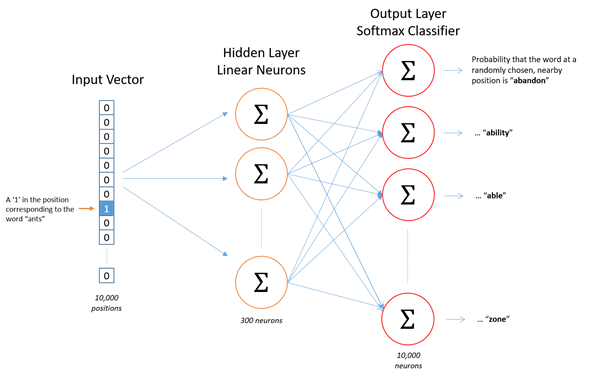

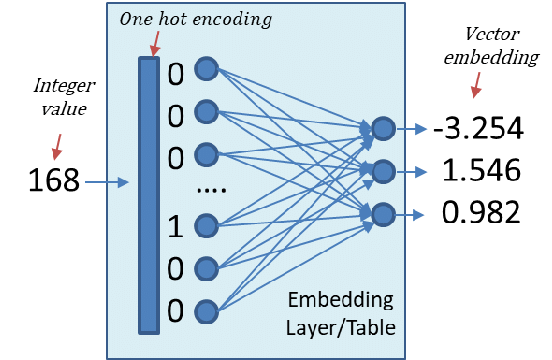